# Introduction

In this notebook, we analyse a sample of PBMCs. Here, we cover the initial filtering and quality control.

## Load packages

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [2]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anndata2ri          1.0.6
annoy               NA
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
fbpca               NA
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
intervaltree        NA
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisol

Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all `seaborn` plots. You can set the context as well to 'talk' or 'paper'.

In [3]:
sb.set_context(context='poster')


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)


# Set project file paths

We set up the file paths to the respective directories.

In [5]:
file_path = '/root/host_home/Documents/ICB/Teaching/2103_scanpy_HMGU_presenter/' 
#this is my file path please adapt it to your directory

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [6]:
file_path_raw = file_path + '3k_PBMC/'

The data directory contains all processed data and `anndata` files. 

In [7]:
data_dir = file_path + 'PBMC_docker/data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [8]:
table_dir = file_path + 'PBMC_docker/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [9]:
sc.settings.figdir = file_path + 'PBMC_docker/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [10]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read data

The dataset consists of 3k PBMCs (Human) provided by 10X Genomics. The data is an mtx directory with an `mtx` file (*i.e.* count matrix), two `tsv` files with barcodes (*i.e.* cell indices) and features (*i.e.* gene symbols). `Scanpy` unpacks the files (if the files are in `gz` archive format) and creates an `anndata` object with the `read_10x_mtx` function.    

The dataset is not filtered, yet. 

In [11]:
file_path_raw = file_path_raw + 'raw_gene_bc_matrices/'


In [12]:
adata_raw = sc.read_10x_mtx(path=file_path_raw)

FileNotFoundError: Did not find file /root/host_home/Documents/ICB/Teaching/2103_scanpy_HMGU_presenter/3k_PBMC/raw_gene_bc_matrices/matrix.mtx.gz.

Let us check the dataset size. 

In [14]:
adata_raw.shape

(737280, 33694)

In [15]:
print('Total number of observations: {:d}'.format(adata_raw.n_obs))

Total number of observations: 737280


# Quality control

## Remove empty droplets

The dataset contains an excessive amount of "cells", which are in fact empty droplets. Let us remove these barcodes prior to further quality control. We use emptyDrops to compute if a cell is a cell or an empty droplet.

It must be noted that CellRanger 3.0 has incorporated the EmptyDrops algorithm to distinguish cells from empty droplets.

Prepare input for EmptyDrops.

In [16]:
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

Run EmptyDrops.

In [17]:
%%R -i sparse_mat -i genes -i barcodes -o barcodes_filtered -o ambient_genes

sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes 
ambient <- emptyDrops(counts(sce))
is_cell <- ambient$FDR <= 0.05
threshold_ambient <- 0.005
ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
barcodes_filtered <- barcodes[which(is_cell)]

Empty drops returns a list of potentially ambient genes and the barcodes, which belong to actual cells.

In [18]:
print(ambient_genes)

 [1] "RPL11"  "RPS27"  "RPS27A" "TMSB10" "RPL32"  "RPL34"  "RPS3A"  "RPS14" 
 [9] "HLA-B"  "RPS18"  "EEF1A1" "RPS12"  "ACTB"   "TMSB4X" "RPL10"  "RPL7"  
[17] "RPS6"   "RPLP2"  "FTH1"   "MALAT1" "RPS3"   "RPL41"  "RPL21"  "RPS29" 
[25] "B2M"    "RPLP1"  "RPS2"   "RPS15A" "RPL13"  "RPL19"  "RPL18A" "RPS19" 
[33] "FTL"    "RPL13A" "RPL3"   "MT-CO1" "MT-CO3"



In [19]:
print(barcodes_filtered[:10])

 [1] "AAACCTGAGAAGGCCT-1" "AAACCTGAGACAGACC-1" "AAACCTGAGATAGTCA-1"
 [4] "AAACCTGAGGCATGGT-1" "AAACCTGCAAGGTTCT-1" "AAACCTGCAGGATTGG-1"
 [7] "AAACCTGCAGGCGATA-1" "AAACCTGCATGAAGTA-1" "AAACCTGGTAAATGAC-1"
[10] "AAACCTGGTACATCCA-1"



Let us create a filtered data matrix using the filtered barcodes.

In [20]:
adata = adata_raw[np.in1d(adata_raw.obs_names, barcodes_filtered)].copy()

In [21]:
adata

AnnData object with n_obs × n_vars = 4518 × 33694
    var: 'gene_ids'

**BONUS**: Examine the level of background gene expression.

Save the filtered data set to file.

In [22]:
adata.write(data_dir + 'data_filtered.h5ad')

**COMMENT:** End of 1st session.

## Compute quality control metrics

In [45]:
#adata = sc.read(data_dir + 'data_filtered.h5ad')

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

`Scanpy` provides the `calculate_qc_metrics` function, which computes the following QC metrics:
On the cell level (`.obs` level):
* `n_genes_by_counts`: Number of genes with positive counts in a cell
* `log1p_n_genes_by_counts`: Log(n+1) transformed number of genes with positive counts in a cell
* `total_counts`: Total number of counts for a cell
* `log1p_total_counts`: Log(n+1) transformed total number of counts for a cell
* `pct_counts_in_top_50_genes`: Cumulative percentage of counts for 50 most expressed genes in a cell
* `pct_counts_in_top_100_genes`: Cumulative percentage of counts for 100 most expressed genes in a cell
* `pct_counts_in_top_200_genes`: Cumulative percentage of counts for 200 most expressed genes in a cell
* `pct_counts_in_top_500_genes`: Cumulative percentage of counts for 500 most expressed genes in a cell

On the gene level (`.var` level):
* `n_cells_by_counts`: Number of cells this expression is measured in
* `mean_counts`: Mean expression over all cells
* `log1p_mean_counts`: Log(n+1) transformed mean expression over all cells
* `pct_dropout_by_counts`: Percentage of cells this feature does not appear in
* `total_counts`: Sum of counts for a gene
* `log1p_total_counts`: Log(n+1) transformed sum of counts for a gene

In [23]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

We further aim to determine the fraction of mitochondrial counts per cell.
Please note that mitochondrial genes in human start with 'MT-'

In [24]:
mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['total_counts']

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

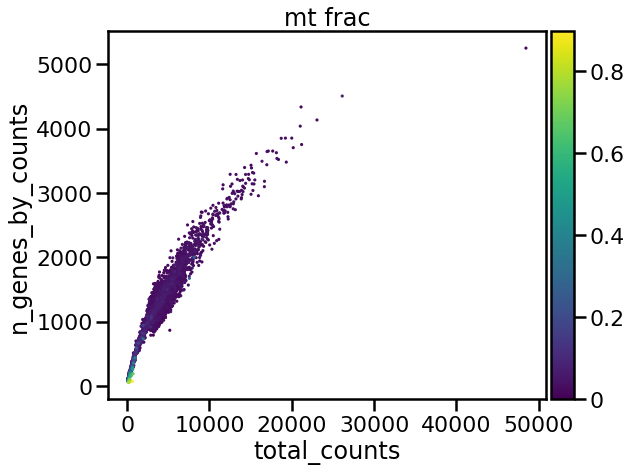

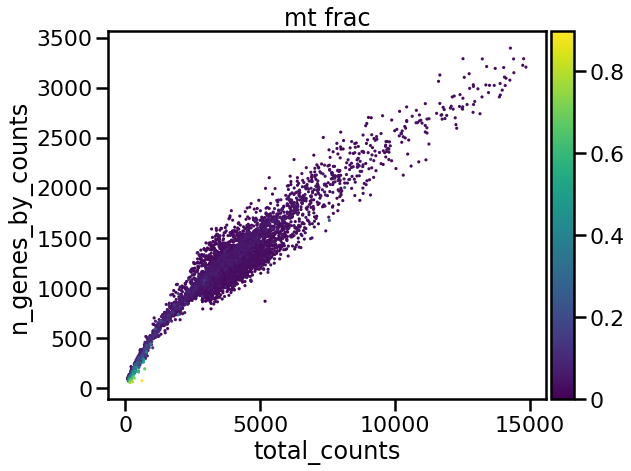

In [25]:
#Data quality summary plots
rcParams['figure.figsize']=(7,7)
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<15000], 'total_counts', 'n_genes_by_counts', 
                   color='mt_frac', size=40)

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


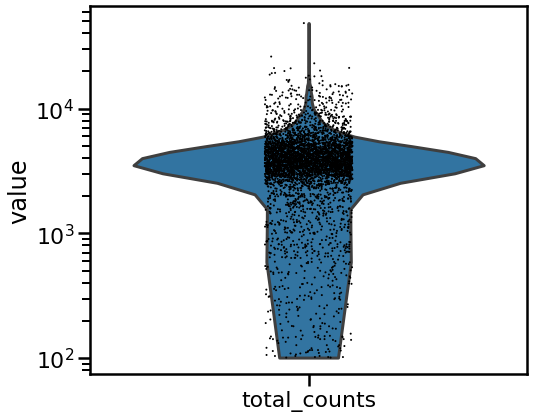

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


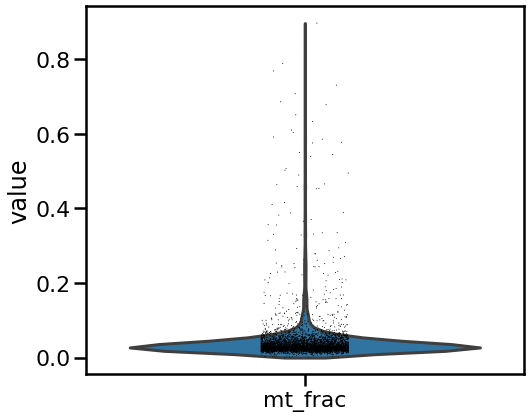

In [26]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t1 = sc.pl.violin(adata, 'total_counts',
                  #groupby='sample',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

Examine the overall library complexity. 
Let us plot the top 50 highest expressed genes first.

normalizing counts per cell
    finished (0:00:00)


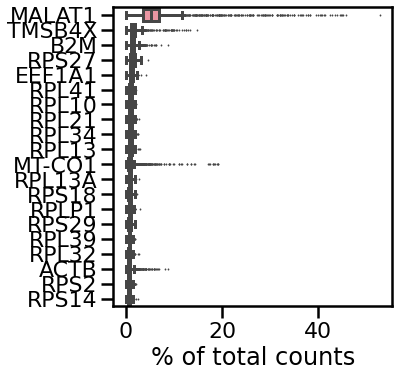

In [27]:
sc.pl.highest_expr_genes(adata, n_top=20)

We expect to see the “usual suspects”, i.e., mitochondrial genes, actin, ribosomal protein, MALAT1. 

How many counts come from the top 50/100/200/500 highest expressed genes? Visualize the fraction as violin plot.

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


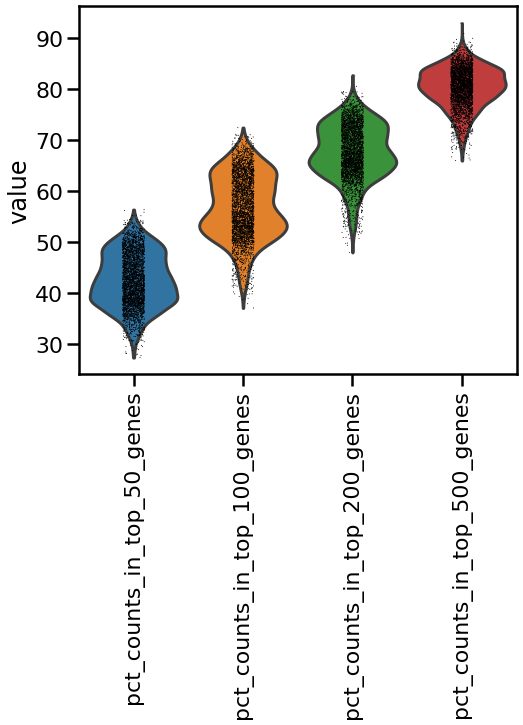

In [43]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t3 = sc.pl.violin(adata, keys=['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 
                     'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
                    ], rotation = 90)


**BONUS:** Visualize the log-transformed total counts vs the log-transformed number of expressed genes with distribution plots on the side of each axis.

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


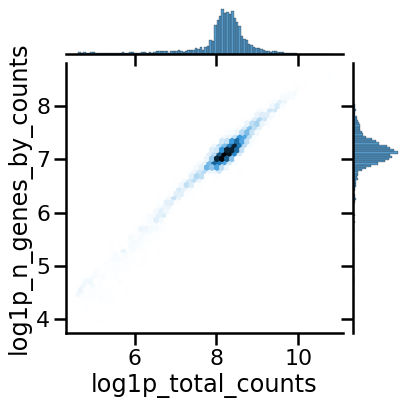

In [29]:
sb.jointplot(
        "log1p_total_counts", 
        "log1p_n_genes_by_counts",
        data=adata.obs, kind="hex"
    )

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly.  We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.

Note: `pandas` does some histogram plotting with `adata.obs['n_counts'].hist()`, however, you will obtain prettier plots with `distplot` from `seaborn`.    

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

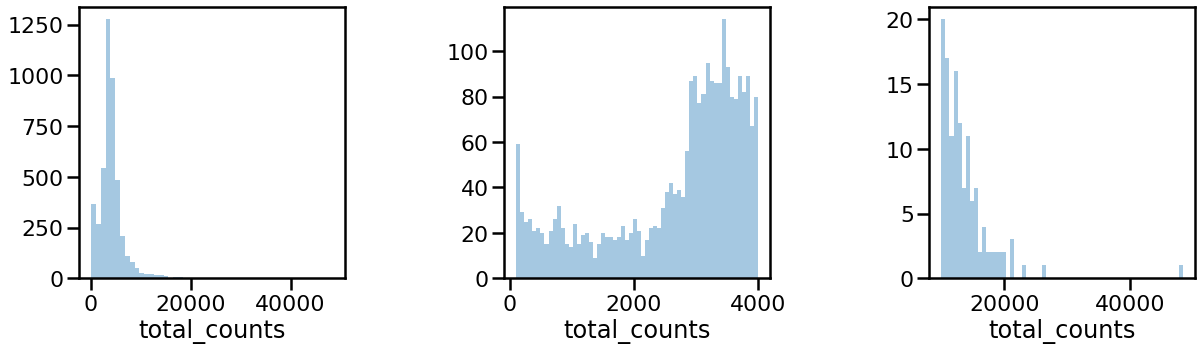

In [31]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['total_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>10000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

Histograms of the number of counts per cell show a small peak of groups of cells with fewer than 1000 counts, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 15,000 counts. We estimate this population to range until 20,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


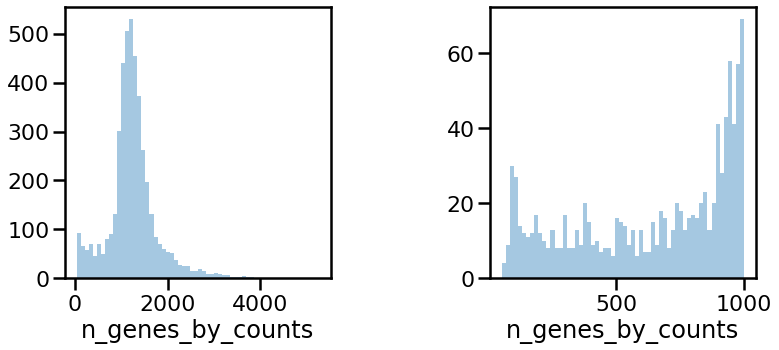

In [32]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


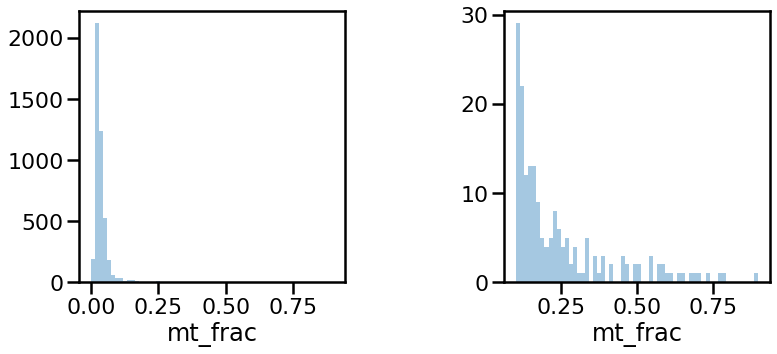

In [33]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.1], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [34]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 4518
filtered out 343 cells that have less than 1000 counts
Number of cells after min count filter: 4175
filtered out 7 cells that have more than 20000 counts
Number of cells after max count filter: 4168
Number of cells after MT filter: 4164
filtered out 147 cells that have less than 700 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 4017


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [35]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
filtered out 21456 genes that are detected in less than 20 cells
Number of genes after cell filter: 12238


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

### Doublet score

Let us estimate the amount of doublets in the dataset.

In [36]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [37]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 49.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 6.8 seconds


/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


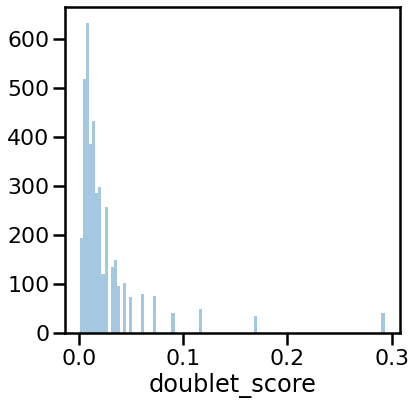

/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


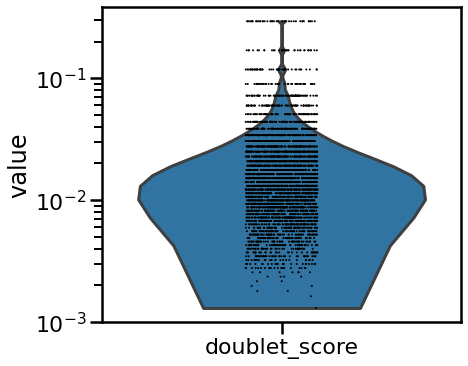

In [38]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()


sc.pl.violin(adata, 'doublet_score',
                  size=2, log=True, cut=0)

### filtering doublets

Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [39]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 3618


### Summarize sample information

In order to group by `batch` (for future purposes, because we presently deal with one sample), let us add a `batch` covariate to the `adata` object. 

In [44]:
adata.obs['batch'] = '1'

df = adata.obs[['n_genes_by_counts','total_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes_by_counts'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['total_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['total_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
batch,,,,
1,1337.287175,1247.0,4357.376953,3916.0


In [45]:
df_all.to_csv(table_dir + 'data_overview.csv')

Save filtered data to file.

In [42]:
adata.write(data_dir + 'data_postQC.h5ad')

... storing 'batch' as categorical


**COMMENT:** End of second session and day 1. 